## MARBL diagnostics for ocean history files: 

### MARBL - SCOPE (Standard Carbon and Ocean Plankton Ecosystem)

##

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image
import utils
import pandas as pd
import pop_tools

import tools

### Define latest year and get the CESM data

In [2]:
year = 35
case = 'g.e22.G1850ECOIAF_JRA_HR.TL319_t13.scope_tunerun'
user = 'kristenk'

In [3]:
yr4="{:04d}".format(year)
month = 6
mo2="{:02d}".format(month)
file = f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc'

In [4]:
ds=xr.open_mfdataset(file)

### Keep only the variables we need

In [5]:
variables = ['sp_Fe_lim_Cweight_avg_100m','sp_P_lim_Cweight_avg_100m','sp_N_lim_Cweight_avg_100m',
             'diat_Fe_lim_Cweight_avg_100m', 'diat_P_lim_Cweight_avg_100m','diat_N_lim_Cweight_avg_100m',
             'diat_SiO3_lim_Cweight_avg_100m','diaz_P_lim_Cweight_avg_100m',
             'diaz_Fe_lim_Cweight_avg_100m','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_Cweight_avg_100m','cocco_C_lim_Cweight_avg_100m','cocco_N_lim_Cweight_avg_100m',
             'cocco_P_lim_Cweight_avg_100m','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'coccoCaCO3','diatC', 'coccoC','spC','diazC','SALT',
             'PO4','Fe','NO3','SiO3','ALK','photoC_TOT_zint_100m',
            'microzooC','mesozooC',
            'IFRAC','diaz_Nfix',
            'spChl','diatChl','diazChl','coccoChl'] 
coords = {'x':'TLONG','y':'TLAT'}

In [6]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [7]:
ds = ds.squeeze()
ds

<xarray.Dataset>
Dimensions:                         (d2: 2, nlat: 2400, nlon: 3600, z_t: 62, z_t_150m: 15)
Coordinates:
  * z_t                             (z_t) float32 500.0 1.5e+03 ... 5.875e+05
  * z_t_150m                        (z_t_150m) float32 500.0 ... 1.45e+04
    TLONG                           (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                            (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/43)
    time_bound                      (d2) object dask.array<chunksize=(2,), meta=np.ndarray>
    dz                              (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                             (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK                     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAREA                           (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SALT                            (z_t, nlat, nlon) float32 dask.array<chunksize=(62, 2400, 3600), meta=np.ndarray>
    ...                              ...
    diatC                           (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    diazChl                         (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    diazC                           (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    coccoChl                        (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    coccoC                          (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    coccoCaCO3                      (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
Attributes:
    title:             g.e22.G1850ECOIAF_JRA_HR.TL319_t13.scope_tunerun
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2022-05-15 at 11:05:42.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [8]:
ds['photoC_TOT_zint'] = ds['photoC_cocco_zint'] + ds['photoC_sp_zint'] + ds['photoC_diat_zint'] + ds['photoC_diaz_zint']

In [9]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
depths=ds_grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_grid.dz * 0.01

### Phytoplankton nutrient limitation at surface

In [10]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((ds.sp_P_lim_Cweight_avg_100m, ds.sp_Fe_lim_Cweight_avg_100m,ds.sp_N_lim_Cweight_avg_100m),dim='nutrient')
limarray_diat=xr.concat((ds.diat_P_lim_Cweight_avg_100m, ds.diat_Fe_lim_Cweight_avg_100m, ds.diat_N_lim_Cweight_avg_100m, ds.diat_SiO3_lim_Cweight_avg_100m),dim='nutrient')
limarray_diaz=xr.concat((ds.diaz_P_lim_Cweight_avg_100m, ds.diaz_Fe_lim_Cweight_avg_100m),dim='nutrient')
limarray_cocco=xr.concat((ds.cocco_P_lim_Cweight_avg_100m, ds.cocco_Fe_lim_Cweight_avg_100m, ds.cocco_N_lim_Cweight_avg_100m, ds.cocco_C_lim_Cweight_avg_100m),dim='nutrient')

In [11]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(ds.sp_N_lim_Cweight_avg_100m.squeeze())

In [12]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()
most_lim_cocco = most_lim_cocco.squeeze()

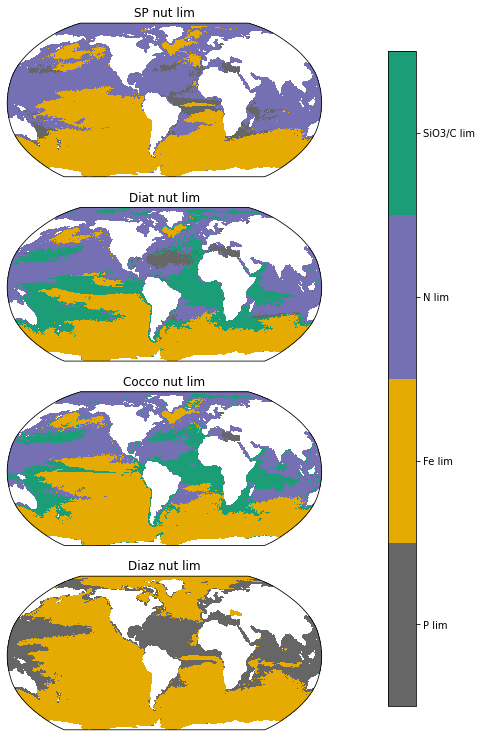

In [13]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_cocco.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

In [14]:
ds.coccoC

<xarray.DataArray 'coccoC' (z_t_150m: 15, nlat: 2400, nlon: 3600)>
dask.array<getitem, shape=(15, 2400, 3600), dtype=float32, chunksize=(15, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Coccolithophores Carbon
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

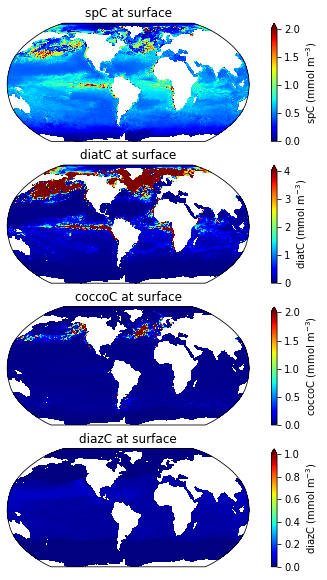

In [15]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

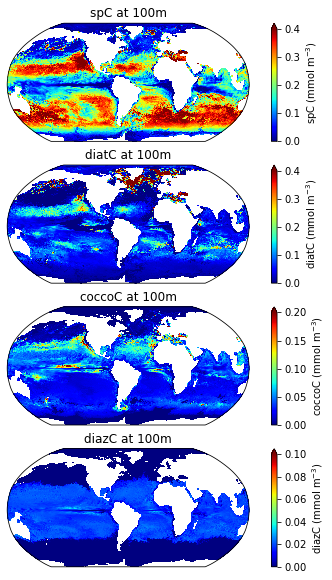

In [16]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

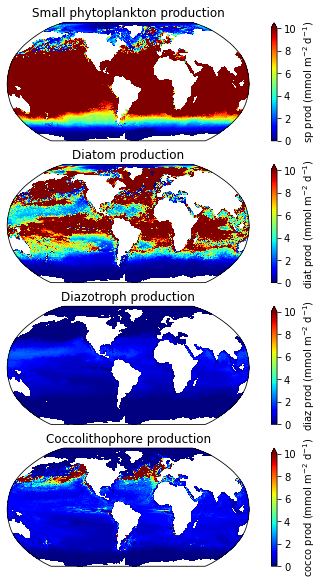

In [17]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = ds.photoC_sp_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = ds.photoC_diat_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = ds.photoC_diaz_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = ds.photoC_cocco_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)')

### Look at percent phytoC

In [18]:
phytoC = ds.spC + ds.diatC + ds.diazC + ds.coccoC
perc_sp = ds.spC / (phytoC) * 100.
perc_cocco = ds.coccoC / (phytoC) * 100.
perc_diat = ds.diatC / (phytoC) * 100.
perc_diaz = ds.diazC / (phytoC) * 100.

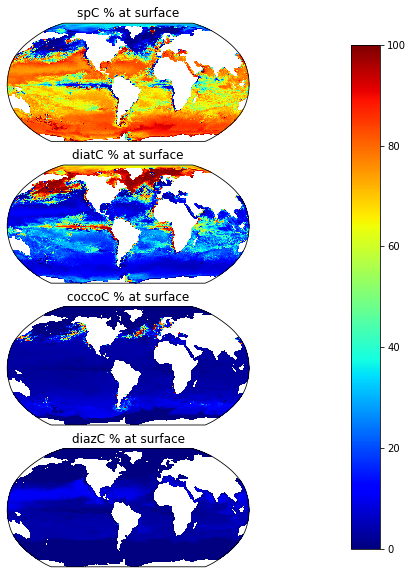

In [19]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_cocco.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_diat.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_sp.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_diaz.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

### Plot zooC

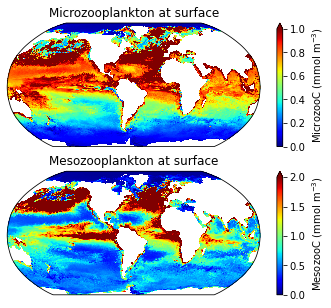

In [20]:
fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.microzooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MicrozooC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.mesozooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MesozooC (mmol m$^{-3}$)');


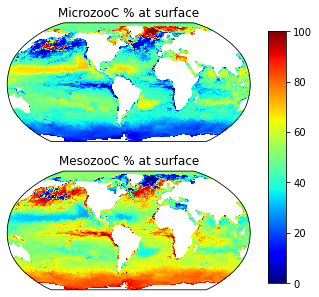

In [21]:
zooC = ds.microzooC + ds.mesozooC
perc_microzoo = ds.microzooC / (zooC) * 100.
perc_mesozoo = ds.mesozooC / (zooC) * 100.

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MicrozooC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_microzoo.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MesozooC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_mesozoo.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax);

### NPP

In [22]:
days_per_month = 30

In [23]:
nmols_to_PgCmonth = 1e-9 * 12. * 1e-15 * days_per_month * 86400.

In [24]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCmonth        
    ds_glb[v].attrs['units'] = 'Pg C month$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 1.738
    photoC_sp_zint     float64 2.271
    photoC_diaz_zint   float64 0.06998
    photoC_cocco_zint  float64 0.208
    photoC_TOT_zint    float64 4.286

In [25]:
print('diatom NPP is ', np.round((ds_glb['photoC_diat_zint']/ds_glb['photoC_TOT_zint']*100.).values,2),'% of total NPP.')

diatom NPP is  40.54 % of total NPP.


### COPEPOD comparison (Mesozooplankton)

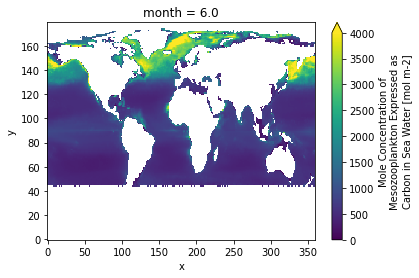

In [26]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod = xr.open_dataset(file)

ds_copepod.zmeso200.isel(month=5).plot(vmin=0,vmax=4000) #['copepod_C']=ds_copepod.copepod_C/12.011

In [27]:
tmp = (ds.mesozooC * 10).sum(dim='z_t_150m').where(ds_grid.REGION_MASK > 0)

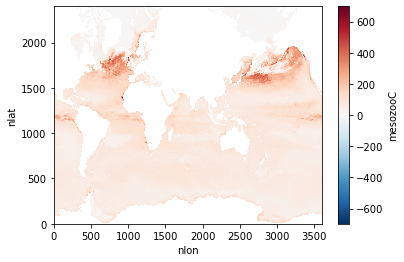

In [28]:
tmp.plot()

In [29]:
# fig = plt.figure(figsize=(12,3))

# ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('COPEPOD dataset', fontsize=12)
# tmp = ds_copepod.copepod_C
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
# pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
# ax.coastlines('110m',linewidth=0.5)
# ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
# ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
# tmp = (cesm_ann_ds.mesozooC * 10).sum(dim='z_t_150m')
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
# pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
# ax.coastlines('110m',linewidth=0.5)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mesozoo (mmol m$^{-2}$)')

### Calcification

In [30]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCmonth
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',np.round(ds_glb['CaCO3_PROD_zint'].values,4), 'Pg C per month')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 0.0714 Pg C per month
(should be between 0.6 to 2.4 Pg C per year)


In [31]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/Monthly_clim_PIC/06-A20031522018181.L3m_MC_PIC_pic_9km.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)

#convert to mol/m3 from mmol/m3
ds_pic['pic']=ds_pic.pic * 1000.

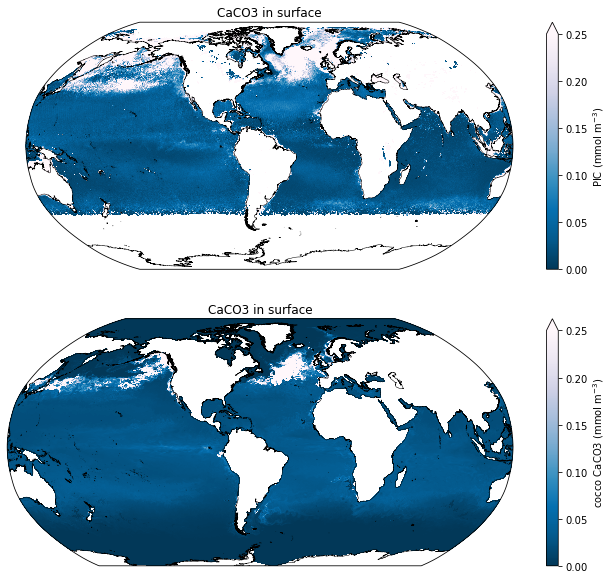

In [32]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.pic, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.coccoCaCO3.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


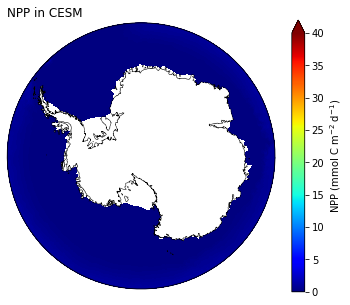

In [34]:
fig = plt.figure(figsize=(6,5))

import matplotlib.path as mpath
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP in CESM', loc='left')
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint*86400*0.01)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=40, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol C m$^{-2}$ d$^{-1}$)')

#fig.savefig('/glade/work/kristenk/figs/npp.png', bbox_inches='tight', dpi=300, format='png');